# Table of Contents

[Initialization](#1)

[Introduction](#2)

[Loading Data & Preprocessing](#3)

[Exploratory Data Analysis (EDA)](#4)
- [Findings](#4.1)

[Model Creating & Training](#5)
- [Preparing the Script to Run on the GPU Platform](#5.1)
- [Output](#5.2)

[Conclusion](#6)

## Initialization

<a id = 1></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img

## Introduction <a id = 2></a>

The supermarket chain **Good Seed** is introducing a computer vision system for processing customer photos. Specifically, they are introducing cameras in the checkout area which are triggered when a customer is buying alcohol. This photofixation in the checkout area can help them adhere to alcohol laws by making sure they do not sell alcohol to underage people. 

My task is to build and evaluate a model that can verify a customer's age. In order for the model to be deemed good enough, the mean absolute error (MAE) value of the test set may not be higher than 8.

## Loading Data & Preprocessing <a id = 3></a>

The dataset is stored in the `/datasets/faces/` folder. There one can find the following:
- The `final_files` folder with 7591 photos
- The `labels.csv` file which has two columns: `file_name` and `real_age`

Since the number of image files is rather high, I will avoid reading them all at once, as this would greatly consume computational resources.

In [2]:
faces_labels = pd.read_csv('/datasets/faces/labels.csv')

What is the shape of the **faces_labels** dataframe? Does it have any null values?

In [3]:
faces_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


The shape is (7591, 2), as expected, and there are no null values. Great! Additionally, the Dtypes are appropriate.

I wonder if there are any rows that are exact duplicates? If so, they should be dropped.

In [4]:
faces_labels.duplicated().sum()

0

The above result implies that there are no rows that are exact duplicates. Great! 

Now I will display the top 5 rows and the bottom 5 rows to get a feel for what the dataframe looks like.

In [5]:
faces_labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
faces_labels.tail()

,file_name,real_age
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


All of the file names are six digit numbers, the first one being 000000. Interestingly enough, I would have expected the last **file_name** to be 007590 (since 7590 is the last index value), but in actuality it is 007612. Perhaps this is because some photos (possibly 7613 – 7591 = 22 of them) were deleted from the dataframe, and then the index was reset.

## Exploratory Data Analysis (EDA) <a id = 4></a>

Now that I have completed data preprocessing, let's do some exploratory data analysis. Specifically, it would be good to have an idea of the distribution of the ages present in the dataframe.

In [7]:
faces_labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In the United States of America, the legal drinking age is 21, and 25% of the people in this dataframe are under 21. Though only a minority of the people in the dataframe are too young to buy alcohol, I am sure that 25% is a large enough percentage to the point that I do not need to worry about there being any kind of class imbalance. (In contrast, if, hypothetically, only 1% of the people in the dataframe are under 21, then I would be concerned about how well the model is able to perform.)

Interestingly, only 25% of the people in the dataframe are over 41. I don't think this is a problem, however, because the model does not need a lot of data of faces of people who are in their forties or over. After all, if a customer appears to be at least 42 years old to a human employee of **Good Seed** then it is extremely unlikely that the customer is actually less than 21 years old. 

I find it a little strange that the dataframe has at least one person who is only 1 year old, and at least one other person who is at least 100 years old. These are both extreme values in the context of a person going shopping (a 1-year-old child is obviously too young to understand what grocery shopping is, and only a tiny percentage of people live to be 100). I was tempted to remove such extreme values from the dataframe, but I decided not to because I think it will only help the model if it is trained to handle such a wide array of ages.

Lastly, I think it is great that half of the data comprises of people who are 29 or under, because this makes me think that the model should have enough data to be able to distinguish between people who are just under 21 as well as just over 21. (Of course, I will only know this for sure after I build the model and assess it using an appropriate metric.)

Thanks to the **describe** function, I was able to see the summary statistics of the dataframe, which gives me an idea of the distribution of ages. However, a histogram would give a more complete picture of the distribution, so I plot one on the next line. I deliberately chose 5 as the bin size because I would argue that when it comes to adults, after 5 years a person's physical appearance is not likely to have changed that drastically (e.g. a person who is currently 45 years old probably did not look very different when they were 40). Hence, it seems appropriate to put people who are up to 5 years apart into the same bin.

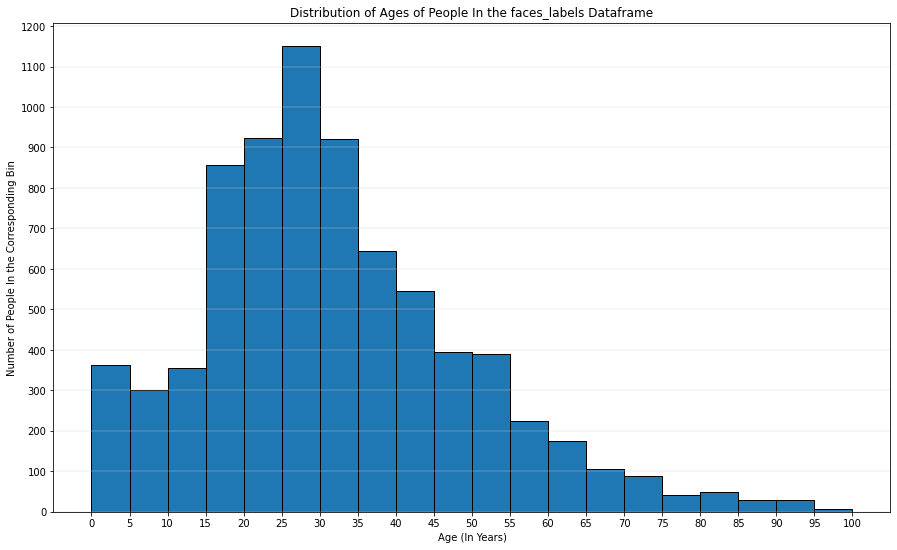

In [8]:
plt.figure(figsize = (15, 9))
faces_labels['real_age'].plot(kind = 'hist', bins = np.arange(0, 105, 5), edgecolor = 'black', linewidth = 1)

plt.title('Distribution of Ages of People In the faces_labels Dataframe')
plt.xlabel('Age (In Years)')
plt.xticks(np.arange(0, 105, 5))
plt.ylabel('Number of People In the Corresponding Bin')
plt.yticks(np.arange(0, 1300, 100))

for y_tick in plt.gca().get_yticks():
    plt.axhline(y = y_tick, color = 'lightgray', linestyle = '-', alpha = 0.25)

As implied by the summary statistics, this is a right-tailed distribution. I think it is great that there is a relatively large number of photos of people in the 15 to 20, 20 to 25, and 25 to 30 bins, as these are the bins where it is most imperative for **Good Seed** to have a model that accurately guesses a customer's age if the customer is attempting to buy alcohol.

It is a good idea to print a set of photos to get an overall impression of them. I will print 15 in total, one for each of the following ages: 10, 15, 20, ... , 70, 75, 80. 

Increasing by 5 seems appropriate because this is what the histogram does, and also because doing this covers the majority of the 1 to 100 age range.

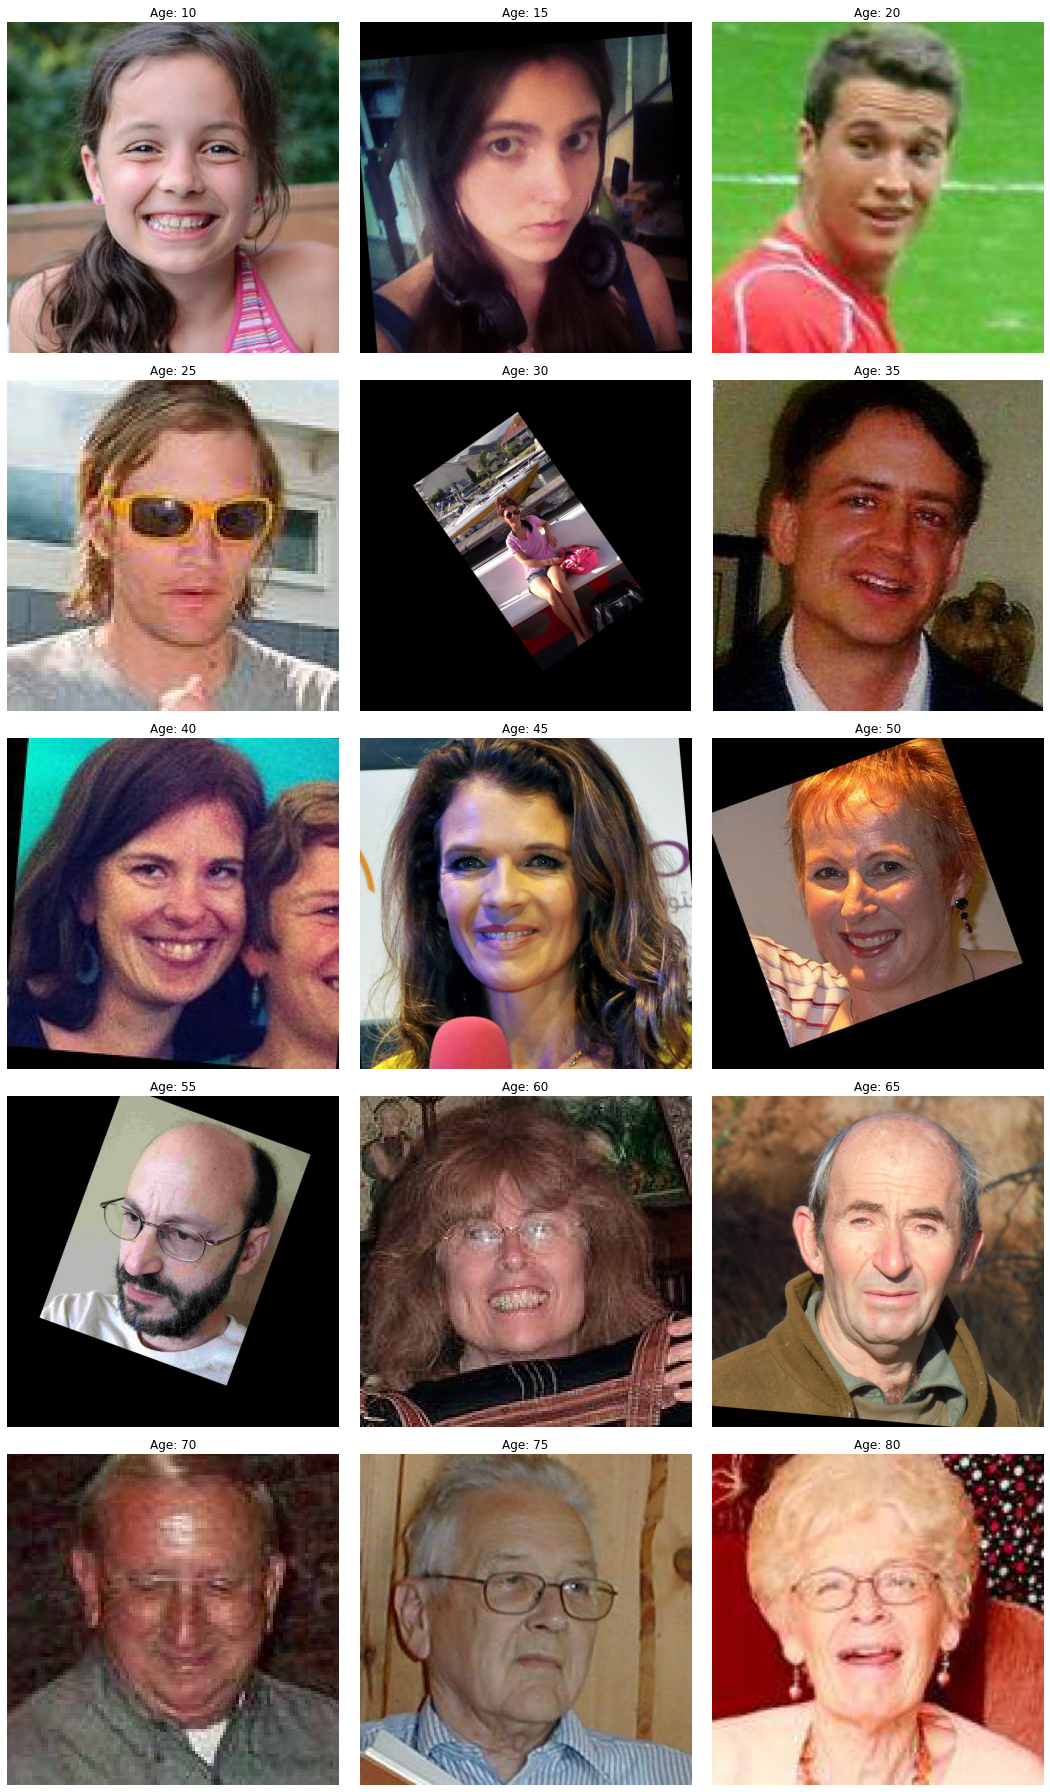

In [9]:
fig, axes = plt.subplots(5, 3, figsize = (15, 5 * 5))
axes = axes.flatten()

for i, age in enumerate([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]):
    
    file_name = faces_labels[faces_labels['real_age'] == age]['file_name'].values[0]
    photo_path = os.path.join('/datasets/faces/', "final_files", file_name)
    photo = load_img(photo_path)

    axes[i].imshow(photo)
    axes[i].set_title(f"Age: {age}")
    axes[i].axis("off")
    
plt.tight_layout()
plt.show()

Unfortunately, this small sample of photos reveals that there are many problems with the photos in the dataset. Specifically... 
- The age 15 photo is fairly blurry.
- The age 20 photo is even blurrier than that of the 15-year-old.
- The age 25 photo is blurry and the person is wearing sunglasses, which partially obstructs his face.
- The age 30 photo is a zoomed out photo of (nearly) the whole person's body. She is also wearing sunglasses, so it is difficult to analyze her face.
- The age 35 photo is blurry.
- The age 40 photo is blurry, and it partially contains a second person's face.
- The age 50 photo has a lot of large black borders (similar to, but not as bad as, the age 30 photo).
- The age 55 photo consists of a man looking diagonally downwards instead of straight at the camera. The black borders might be an issue as well.
- The age 60 photo is blurry.
- The age 70 photo is (very) blurry.
- The age 80 photo is blurry.

### Findings <a id = 4.1></a>

I have mixed feelings about the quality of this dataset. 

On the bright side, I did not drop any of the rows during data preprocessing, which makes me optimistic that 7,591 photos are enough to build a useful model. Furthermore, the distribution of ages is right-tailed, meaning it has more younger people than older, which is great because it is in **Good Seed's** best interest to have a model that can accurately calculate the ages of young people who are around the drinking age of 21. (In fact, the age bins from 15 to 20, 20 to 25, and 25 to 30 have some of the largest numbers of photos.)

Unfortunately, the sample of 15 photos I printed strongly suggests that there are many flaws with the photos. The most common issue I saw is that many of the photos are blurry, which can make it difficult for the model to identify facial features, such as wrinkles, that give an idea of how old a customer is. To a lesser extent, I also observed photos with overly large black borders, photos where the person is not looking straight ahead, and photos where the person's face is partially obstructed (namely, the person is wearing sunglasses), to name just a few issues.

I am concerned that the flaws of the photos will cause the model to have an unacceptably high margin of error, but to help remedy this to some extent I can use augmentation. Specifically... 
- Horizontal flips seem appropriate to use. A customer might angle their face slightly to the left or to the right, and because the dataset has these kinds of photos, augmenting the dataset with horizontal flips might better train the model with handling angled photos.
- Zooming in might be a great idea. Some of the faces in the dataset are not up close, making it challenging to analyze them unless one zooms in on them. I suspect that zooming in up to 20% would be reasonable.
- Rotating some of the photos is likely to help the model. Some customers might have their heads tilted at an angle when their photo is taken, and the model needs to be able to handle this situation. I think rotating some of the photos up to 30°, clockwise or counterclockwise, is reasonable.

## Model Creating & Training <a id = 5></a>

In this section, I define the necessary functions to train the model on the GPU platform, and also build a single script containing all of them along with the initialization section.

In [10]:
def load_train(path):
    
    """
    The code below loads the training part of the dataset from path.
    """
    
    train_datagen = ImageDataGenerator(horizontal_flip = True, rescale = 1/255, rotation_range = 30,
                                       validation_split = 0.25, zoom_range = 0.2)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(batch_size = 16, class_mode = 'raw', dataframe = faces_labels,
                                                           directory = '/datasets/faces/final_files/', seed = 12345,
                                                           subset = 'training', target_size = (150, 150), 
                                                           x_col = 'file_name', y_col = 'real_age')
         
    return train_datagen_flow

In [11]:
def load_test(path):
    
    """
    The code below loads the test part of the dataset from path.
    """
    
    test_datagen = ImageDataGenerator(rescale = 1/255, validation_split = 0.25)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(batch_size = 16, class_mode = 'raw', dataframe = faces_labels,
                                                         directory = '/datasets/faces/final_files/', seed = 12345,
                                                         subset = 'validation', target_size = (150, 150), 
                                                         x_col = 'file_name', y_col = 'real_age')
    
    return test_datagen_flow

The purpose of this Markdown comment is to give me the opportunity to explain my choices regarding how I create the model.
- I use the ResNet50 model as a backbone, partially because the **weights = 'imagenet'** parameter loads the pre-trained weights from the ImageNet dataset, meaning training time is reduced and the weights are able to help the model identify key features in the photos.


- **GlobalAveragePooling2D()** reduces each spatial dimension of a photo to 1 by taking the average of the corresponding pixels values.


- Since this is a regression task, it is appropriate to use **relu** as the activation function. (In contrast, if this was a classification task, then **sigmoid** would be a better choice.) The ReLu function doesn't change the positive numbers, and it brings all the negative ones to zero, which is perfect for a task about ages.


- I add a dropout layer with a dropout rate of 0.5, meaning that a randomly selected 50% of the connections made during the model's training get dropped, which can help prevent overfitting.


- The second (and final) **Dense** layer is the output layer, and I only need one neuron to return the predicted age of a person. 


- **Adam** is a great optimizer to use because the Adam algorithm makes stride selection automatic, which helps the model training strike the balance between not taking too long while also be accurate enough.

In [12]:
def create_model(input_shape):
    
    """
    The code below creates the model.
    """
    
    backbone = ResNet50(input_shape = input_shape, weights = 'imagenet', include_top = False)
    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'relu'))
    
    model.compile(loss = 'mse', optimizer = Adam(lr = 0.0001), metrics = ['mae'])
    
    return model

In [13]:
def train_model(model, train_data, test_data, batch_size = None, epochs = 15,
                steps_per_epoch = None, validation_steps = None):

    """
    The code below trains the model.
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data, validation_data = test_data, batch_size = batch_size, epochs = epochs,
              steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, verbose = 2)

    return model

### Preparing the Script to Run on the GPU Platform <a id = 5.1></a>

Now that I have defined the necessary functions, I am able to compose a script for the GPU platform. The script is in the next line.

In [14]:
# The code below prepares a script that will run on the GPU platform.

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output <a id = 5.2></a>

As shown in the following screenshot, the model successfully acquires a MAE value for the test set that is less than 8. Furthermore, with the exception of the first epoch, the MAE values of the training set are similar to the corresponding MAE values of the test set, which is fantastic because this suggests that the model is not overfitting the training set.

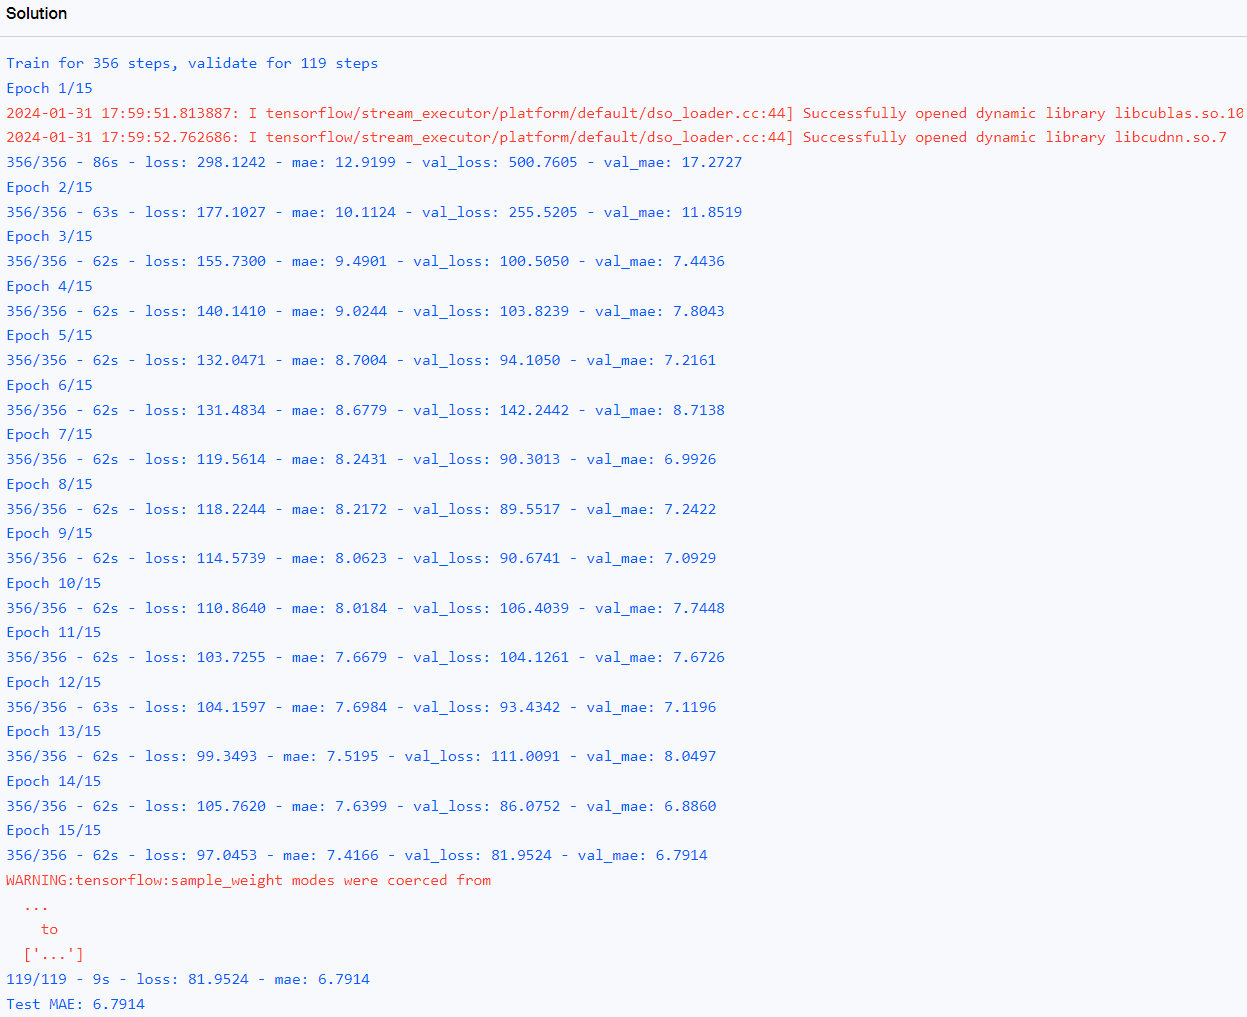

Using 64 the first time **Dense** is added, setting the **Dropout** value to 0.5, setting the learning rate of the **Adam** optimizer to 0.0001, and using 15 **epochs** are all, admittedly, arbitrarily chosen values.

I think it is worth mentioning my attempts with trying different values. Instead of 64 as the first dense value, I also tried out 32, 50, and 100, and I also alternated between using 10 and 15 epochs.

I also considered toying around with different learning rates and dropout values, but I decided not to because I successfully acquired a MAE value that is less than 7, which is considered by my task givers to be a "great" result.

## Conclusion <a id = 6></a>

I cannot, in good conscience, recommend this model to **Good Seed**. The mean absolute error (6.7914) is too high to reliably distinguish between customers who are too young to buy alcohol from those who are old enough. For context, the model might mistake a 27-year-old for a 20-year-old, which would be an embarrassing mistake on **Good Seed's** part, and/or conversely it might mistake a 20-year-old for a 27-year-old, a mistake that can lead to expensive lawsuits!

I think that **Good Seed** should instead do either of the following:

(1) Forbid customers from using the self-checkout when buying alcohol, and instead require them to checkout with a human cashier who may ask for their ID if it is not obvious that the customer is old enough.

(2) Instead of having the self-checkout machine scan the customer's face when alcohol is being purchased, have the customer scan their ID, which must include a date of birth. It should be feasible to create a model that can scan IDs for the person's date of birth.

If **Good Seed** insists on using this kind of model, then I advise them to collect a lot more high-quality photos. In this context, I define "high-quality" as meaning, "the photo is not blurry, the person does not have anything obstructing their face (e.g. sunglasses), the photo is of only the person's face and not (much) more of their body, the person is looking straight at the camera, and the face is as close to the camera as possible in order to closely capture the whole face.